In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
from keras.applications import ResNet50, Xception
from keras.layers import Conv2D , MaxPooling2D ,Dropout , Flatten , Dense ,BatchNormalization ,Concatenate ,Input 
from keras.models import Sequential ,Model
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

In [4]:
metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [16]:
metadata.count()

lesion_id       10015
image_id        10015
dx              10015
dx_type         10015
age              9958
sex             10015
localization    10015
dtype: int64

In [17]:
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [18]:
metadata['age'] = metadata['age'].fillna(metadata['age'].mean()) 
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

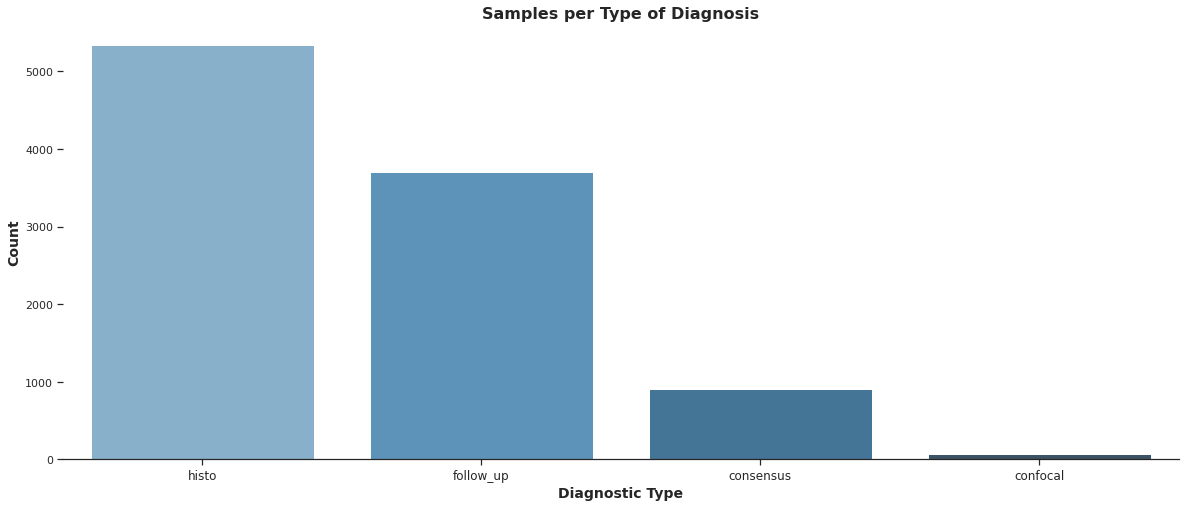

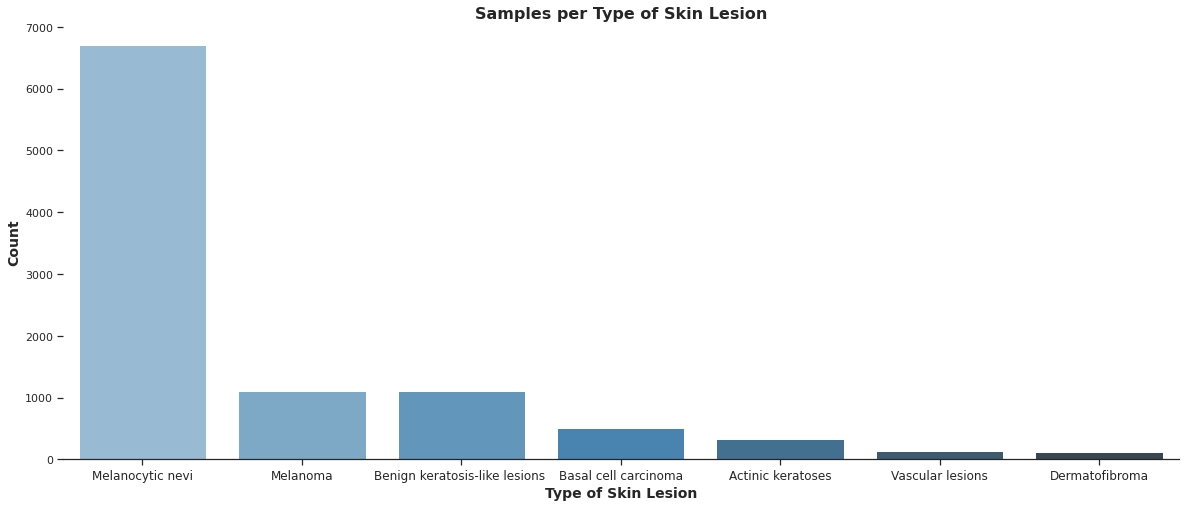

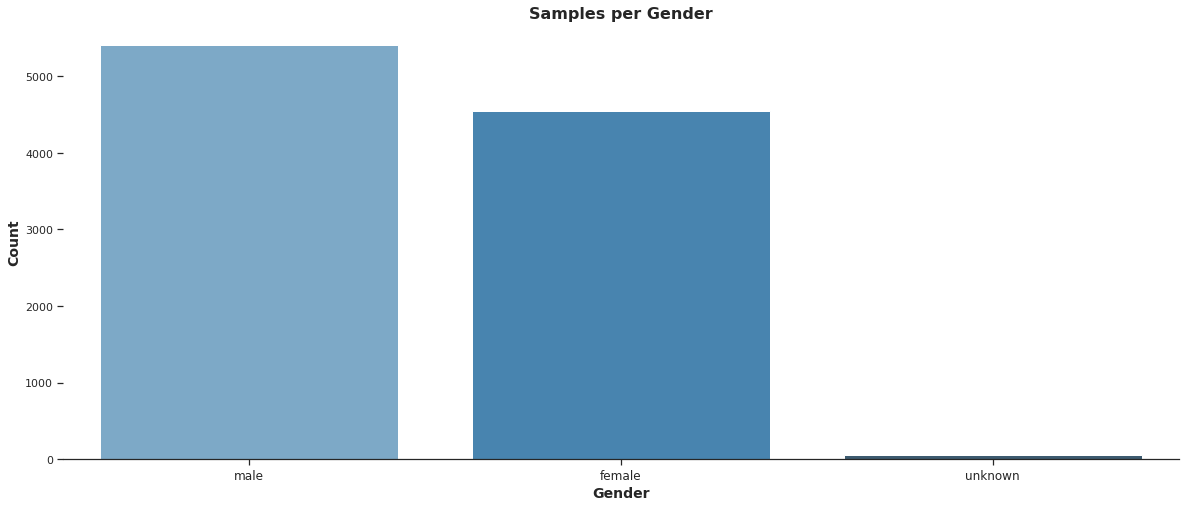

In [46]:
countplot(skin_df,'dx_type', 'Diagnostic Type', 'Count', 'Samples per Type of Diagnosis')
countplot(skin_df,'cell_type', 'Type of Skin Lesion', 'Count', 'Samples per Type of Skin Lesion')
countplot(skin_df,'sex', 'Gender', 'Count', 'Samples per Gender')

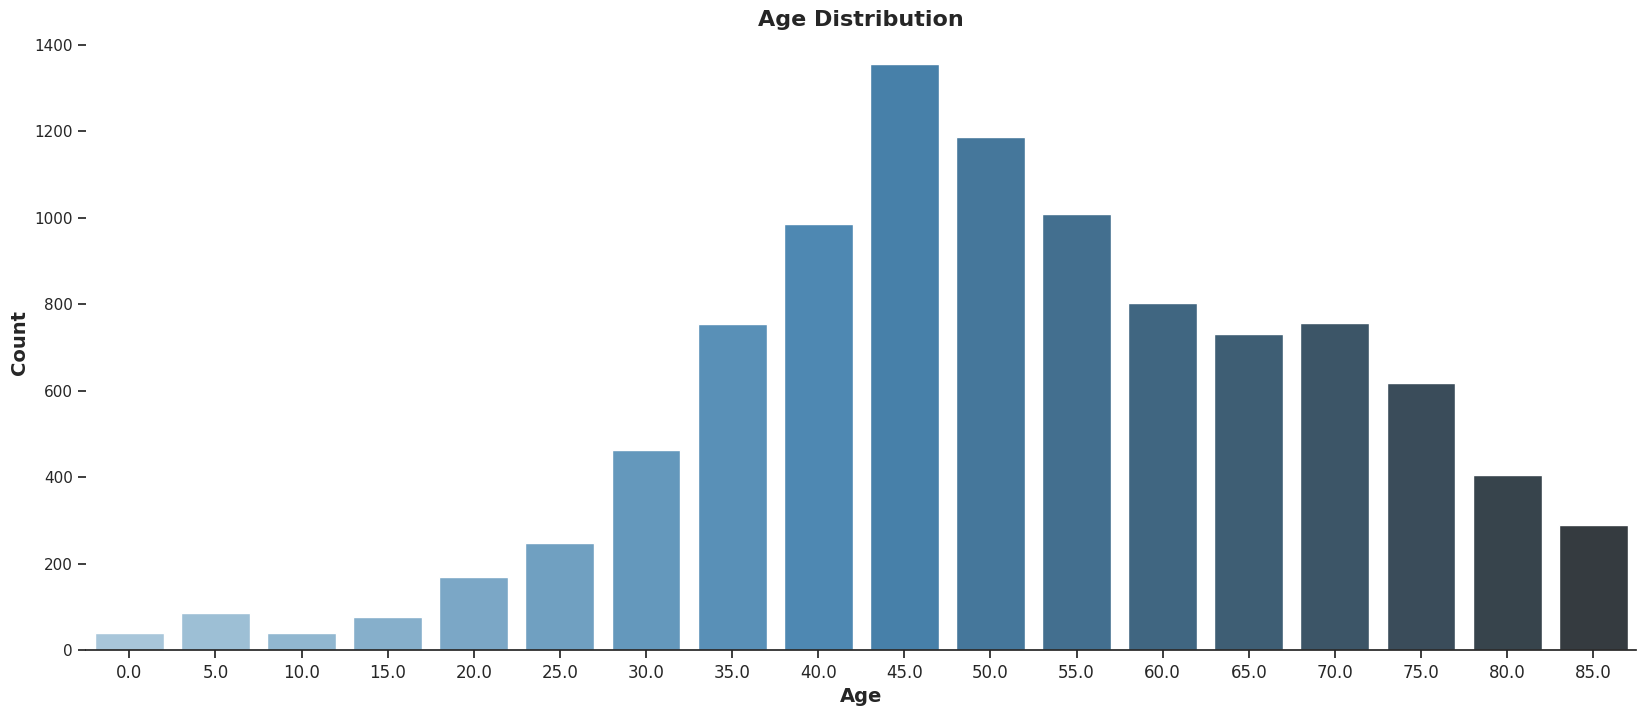

In [11]:
metadata['age'] = metadata['age'].fillna(metadata['age'].mode()[0])

plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = metadata,x='age',palette="Blues_d")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age Distribution', fontsize = 16,weight = 'bold');

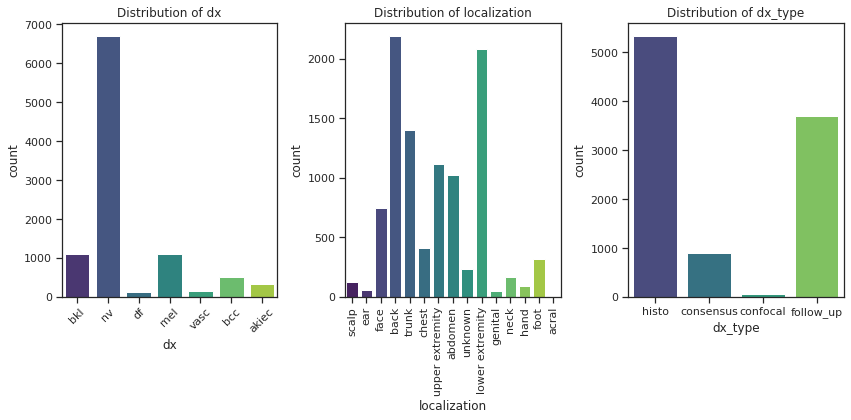

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
sns.countplot(data=metadata , x='dx' ,palette='viridis')
plt.title('Distribution of dx')
plt.xticks(rotation=45)


plt.subplot(1,3,2)
sns.countplot(data=metadata,x='localization' ,palette='viridis')
plt.title('Distribution of localization')
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.countplot(data=metadata , x = 'dx_type' , palette='viridis')
plt.title('Distribution of dx_type')

plt.tight_layout()
plt.show()


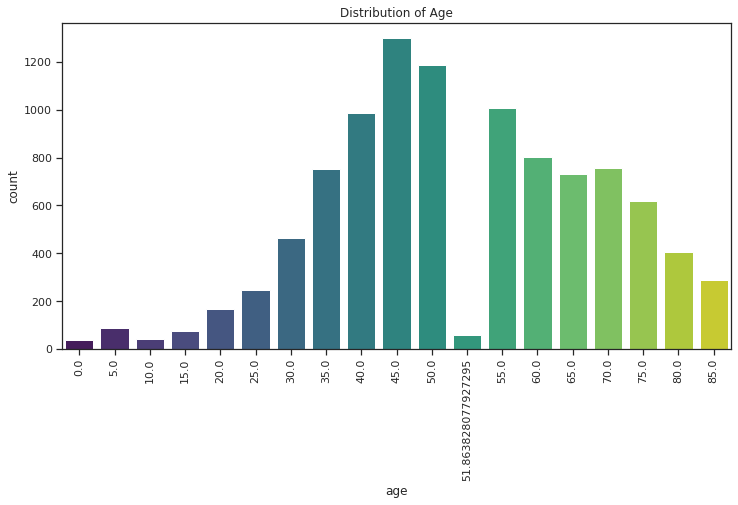

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(data=metadata ,x='age',palette='viridis')
plt.title('Distribution of Age')
plt.xticks(rotation=90)

plt.show()


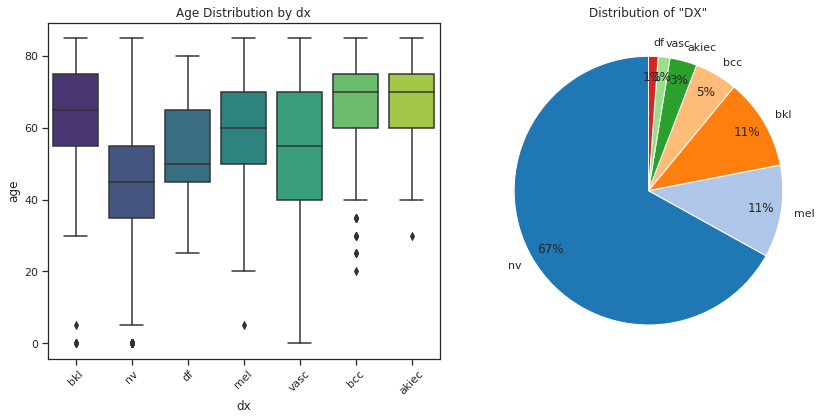

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(data=metadata, x='dx', y='age', palette='viridis')
plt.title('Age Distribution by dx')
plt.xticks(rotation=45)


plt.subplot(1,2,2)
metadata['dx'].value_counts().plot.pie(
    autopct='%1.f%%', 
    startangle=90,      
    colors=sns.color_palette('tab20', len(metadata['dx'].unique())),
    pctdistance=0.85    
)
plt.title('Distribution of "DX"')
plt.ylabel('')

plt.tight_layout()
plt.show()

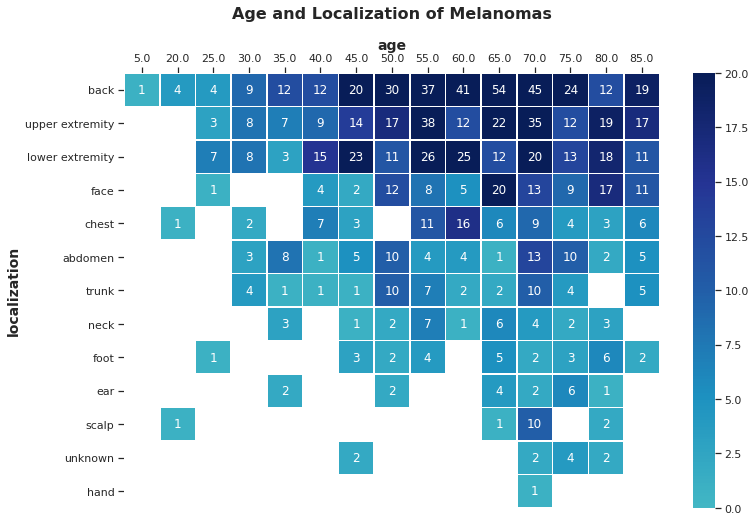

In [45]:
skin_local = skin_mel.groupby(['localization']).size().sort_values(ascending=False, inplace=False).reset_index()
skin_local.columns = ['localization', 'count']
sort_by = skin_local['localization']

skin_heat = skin_mel.groupby(['age','localization']).size().reset_index()
skin_heat.columns = ['age', 'localization', 'count']
skin_heat.sort_values('count', ascending=False, inplace=True)

def heatmap(df, index,columns,values,vmax,sort_by,Title):
    df_wide = df.pivot(index=index, columns=columns, values=values)
    df_wide = df_wide.reindex(index=sort_by)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(df_wide, annot=True, fmt='.0f', yticklabels='auto', cmap=sns.color_palette("YlGnBu", as_cmap=True), center=.2,vmin = 0, vmax = vmax,linewidths=.5)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(columns,fontsize = 14,weight = 'bold')
    ax.set_ylabel(index,fontsize = 14,weight = 'bold')    
    ax.set_title(Title,fontsize = 16,weight = 'bold',pad=20)
    plt.show()
    
heatmap(skin_heat,'localization', 'age','count', 20,sort_by,'Age and Localization of Melanomas')

In [22]:
metadata['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [23]:
def col_values_unique (df):
    for col in df :
        if df[col].dtypes=='object':
            print(col ,f':' ,df[col].unique())
col_values_unique(metadata)

lesion_id : ['HAM_0000118' 'HAM_0002730' 'HAM_0001466' ... 'HAM_0005579' 'HAM_0001576'
 'HAM_0002867']
image_id : ['ISIC_0027419' 'ISIC_0025030' 'ISIC_0026769' ... 'ISIC_0033536'
 'ISIC_0032854' 'ISIC_0032258']
dx : ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
dx_type : ['histo' 'consensus' 'confocal' 'follow_up']
sex : ['male' 'female' 'unknown']
localization : ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


In [24]:
metadata_features = metadata[['age','dx_type' ,'sex','localization']].copy()
# feature encoding
metadata_features = pd.get_dummies(metadata_features , columns=['dx_type' ,'sex','localization'],drop_first=True,dtype=int)
# age normalization
metadata_features['age'] = metadata_features['age']/metadata_features['age'].max()

x_metadata = np.array(metadata_features)
# x_metadata
# metadata_features

In [25]:
label_mapping = {
    "bkl": 0,
    "nv": 1,
    "df": 2,
    "mel": 3,
    "vasc": 4,
    "bcc": 5,
    "akiec": 6
}

In [27]:
def load_image(image_id  , image_folder):
    image_path = os.path.join(image_folder , f'{image_id}.jpg')
    return Image.open(image_path)

image_folder1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_folder2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

image_data = []
labels = []
for idx,row in metadata.iterrows():
    i_id = row['image_id']
    dx   = row['dx']
    
    try:
        image = load_image(i_id , image_folder1)
        
    except FileNotFoundError:
        image = load_image(i_id , image_folder2)
    image = image.resize((128,128))
    image = img_to_array(image) /255.0
    
    image_data.append(image)
    labels.append(label_mapping[dx])
  
    
classes = ["Benign keratosis-like lesions 'bkl'" , "Melanocytic nevi 'nv'" ,"Dermatofibroma 'df'",
           "Melanoma 'mel'","Vascular lesions 'vasc'","Basal cell carcinoma 'bcc'" ,
           'Actinic keratoses and intraepithelial carcinoma "akiec"']

In [28]:
classes[labels[1889]]

"Melanoma 'mel'"

In [30]:
def show_samples(i_dex):
    plt.imshow(image_data[i_dex])
    plt.xlabel(classes[labels[i_dex]])
    plt.show()

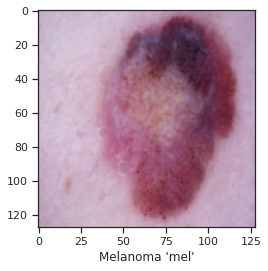

In [31]:
show_samples(1899)

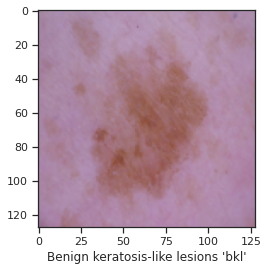

In [32]:
show_samples(802)

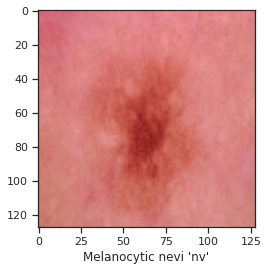

In [33]:
show_samples(6453)

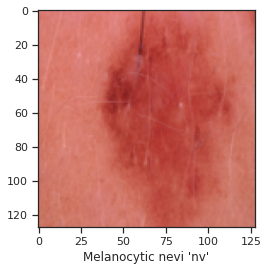

In [34]:
show_samples(4900)

In [35]:
x_image = np.array(image_data)
y = np.array(labels)
y_encoded = pd.get_dummies(y , dtype=int).values
len(y_encoded[1899])

7

In [36]:
classes[np.argmax(y_encoded[1899])]

"Melanoma 'mel'"

In [37]:
x_metadata[22].shape

(20,)

**Model**

In [39]:
# Image Model (CNN)
image_input = Input(shape=(128,128,3) , name='image_input')
x = Conv2D(32,(3,3) , activation='relu')(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64,(3,3) , activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(128,(3,3), activation='relu')(x) 
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(.5)(x)
x = Flatten()(x)

# Metadata Model (ANN)
metadata_input = Input(shape=(x_metadata.shape[1],) , name='metadata_input')
y = Dense(64 ,activation='relu')(metadata_input)
y = Dropout(.2)(y)
y = Dense(32 , activation='relu')(y)

#Models Combination
combined = Concatenate()([x,y])

z = Dense(128 ,activation='relu')(combined)
z = Dropout(.5)(z)
z = Dense(64 , activation='relu')(z)

output = Dense(len(y_encoded[0]) , activation='softmax')(z)
model = Model(inputs=[image_input ,metadata_input] , outputs = output)

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=(['accuracy']))

In [ ]:
base_model = ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');

ResNet50model = Sequential()
ResNet50model.add(base_model)
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(128, activation="relu"))
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(num_classes, activation = 'softmax'))

for layer in base_model.layers:
    layer.trainable = True

ResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet50accuracy = history(ResNet50model)
    
print("ResNet50 Training: accuracy = %f" % (ResNet50accuracy_t))
print("ResNet50 Validation: accuracy = %f" % (ResNet50accuracy_v))
print("ResNet50 Test: accuracy = %f" % (ResNet50accuracy))

In [ ]:
training_shape = (75,100, 3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)

XCeptionmodel = base_model.output
XCeptionmodel = Flatten()(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionmodel = Dense(128, activation='relu')(XCeptionmodel)
XCeptionmodel = Dropout(0.2)(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionoutput = Dense(num_classes, activation = 'softmax')(XCeptionmodel)
XCeptionmodel = Model(inputs=base_model.input, outputs=XCeptionoutput)

for layer in base_model.layers:
    layer.trainable = True

XCeptiony_pred,XCeptionaccuracy_t,XCeptionaccuracy_v,XCeptionaccuracy = history(XCeptionmodel)
    
print("XCeption Training: accuracy = %f" % (XCeptionaccuracy_t))
print("XCeption Validation: accuracy = %f" % (XCeptionaccuracy_v))
print("XCeption Test: accuracy = %f" % (XCeptionaccuracy))

In [40]:
x_train_image , x_test_image , x_train_metadata ,x_test_metadata,y_train ,y_test = train_test_split(x_image,x_metadata , y_encoded ,test_size=.2 ,random_state=42)

history = model.fit([x_train_image ,x_train_metadata] , y_train ,
          validation_data=([x_test_image,x_test_metadata],y_test),batch_size=32 ,validation_split=.2,epochs=50)

Epoch 1/50
201/201 [==============================] - 174s 857ms/step - loss: 1.7548 - accuracy: 0.5900 - val_loss: 1.5148 - val_accuracy: 0.6719
Epoch 2/50
201/201 [==============================] - 175s 871ms/step - loss: 1.0389 - accuracy: 0.6687 - val_loss: 1.0330 - val_accuracy: 0.6719
Epoch 3/50
201/201 [==============================] - 174s 864ms/step - loss: 0.9445 - accuracy: 0.6641 - val_loss: 0.8297 - val_accuracy: 0.6719
Epoch 4/50
201/201 [==============================] - 174s 866ms/step - loss: 0.8847 - accuracy: 0.6598 - val_loss: 0.7826 - val_accuracy: 0.6719
Epoch 5/50
201/201 [==============================] - 174s 866ms/step - loss: 0.8386 - accuracy: 0.6629 - val_loss: 0.7824 - val_accuracy: 0.6700
Epoch 6/50
201/201 [==============================] - 174s 866ms/step - loss: 0.8829 - accuracy: 0.6530 - val_loss: 0.8136 - val_accuracy: 0.6719
Epoch 7/50
201/201 [==============================] - 173s 859ms/step - loss: 0.8160 - accuracy: 0.6794 - val_loss: 0.7598 -

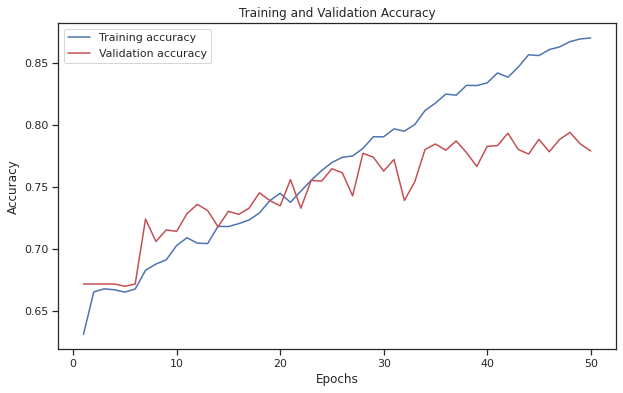

range(1, 51)


In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training & validation accuracy values
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(epochs)

In [42]:
model.evaluate([x_test_image,x_test_metadata] ,y_test)

63/63 [==============================] - 12s 196ms/step - loss: 0.6190 - accuracy: 0.7708


[0.6189965009689331, 0.7708437442779541]